# Transformer

In [1]:
import math
import pandas as pd
import torch
from torch import nn
import d2l_torch as d2l

In [2]:
# 基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.1050,  0.6495, -0.8641, -0.3426, -0.4464, -0.6514,  0.0586, -0.4345],
        [ 0.1050,  0.6495, -0.8641, -0.3426, -0.4464, -0.6514,  0.0586, -0.4345],
        [ 0.1050,  0.6495, -0.8641, -0.3426, -0.4464, -0.6514,  0.0586, -0.4345]],
       grad_fn=<SelectBackward0>)

In [4]:
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

In [5]:
ffn(torch.ones((2, 3, 4)))[0].shape

torch.Size([3, 8])

In [6]:
# 残差连接和层规范化
# 层规范化是基于特征维度进行规范化
# 批量规范化通常不如层规范化效果好

ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [7]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [10]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [11]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [12]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [13]:
# 编码器
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [14]:
# X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
# encoder_blk(X, valid_lens).shape

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [15]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [16]:
# 位置编码
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [17]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [18]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [19]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
# state = [encoder_blk(X, valid_lens), valid_lens, [None]]
# decoder_blk(X, state)[0].shape

In [20]:
# 带有注意力机制的解码器
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def attention_weights(self):
        return self._attention_weights

In [21]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
            self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * len(self.blks)]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

In [22]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [23]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_voccab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/src on {str(device)}')

In [24]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [25]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

loss 0.033, 8051.0 tokens/src on cpu


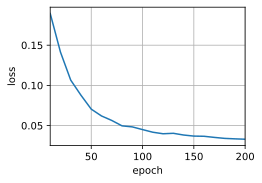

In [26]:
# 训练
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [27]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [28]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation},',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


In [29]:
# 可视化编码器的注意力权重
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
                                                                             -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

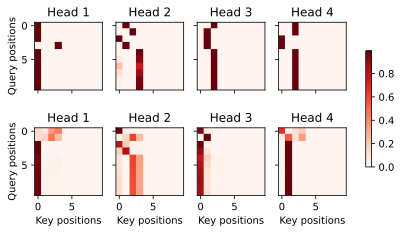

In [30]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [31]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

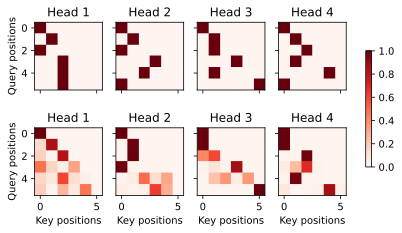

In [32]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

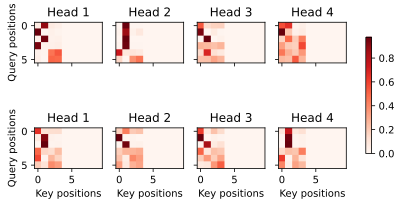

In [33]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))